In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Calculating correlation time:
# --- Parameters ---
folder = "harps_3000"
max_files = 4000  # Set your desired limit
P = 304e-6       # meters
D = 0.125        # meters
lambda0 = 640e-9 # meters

# Convert to angstroms for consistency with wavelength array
P_A = P * 1e10
D_A = D * 1e10
lambda0_A = lambda0 * 1e10
f_cutoff = (np.sqrt(2) / P_A) * (D_A / lambda0_A)  # in 1 / Å

plotted = 0
spectra = []
dates = []
wavelengths = []

# Loop over all .fits files in the folder
for filename in os.listdir(folder):
    if not filename.endswith(".fits"):
        continue
    if plotted >= max_files:
        break

    filepath = os.path.join(folder, filename)
    try:
        hdul = fits.open(filepath)
        data = hdul[1].data[0]  # Extension 1, first row of table
        wavelength = data['WAVE']
        flux = data['FLUX']

        # Define normalization window (in Å)
        # Perhaps do this after filtering.. but not sure
        # Nope, looks best to do this before filtering!!
        norm_min = 5600
        norm_max = 6100

        # Get mask for values within the range
        norm_mask = (wavelength >= norm_min) & (wavelength <= norm_max)

        # Prevent divide-by-zero if no values are in range
        if np.sum(norm_mask) < 10:
            print(f"Skipping {filename}: not enough points in normalization window.")
            continue

        # Compute median in range and normalize
        median_flux = np.median(flux[norm_mask])
        flux = flux / median_flux
        # Check for uniform spacing
        # not gonna band limit this one
        # dw = np.diff(wavelength)
        # if not np.allclose(dw, dw[0], rtol=1e-4):
        #     print(f"Skipping {filename}: wavelength grid not uniform.")
        #     continue

        # # FFT and filtering
        # flux_fft = np.fft.fft(flux)
        # freqs = np.fft.fftfreq(len(flux), d=dw[0])
        # mask = np.abs(freqs) > f_cutoff
        # flux_fft[mask] = 0
        # flux_filtered = np.fft.ifft(flux_fft).real
        obs_date = hdul[0].header.get('DATE-OBS', 'Unknown')


        wavelengths.append(wavelength[norm_mask])
        spectra.append(flux[norm_mask])
        dates.append(obs_date)
        plotted += 1

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

In [3]:
# stack into shape (n_arrays, 50001) and average over the first dimension
mean_spectrum = np.stack(spectra, axis=0).mean(axis=0)

# 2) normalize each array around the mean
norm_spectra = []
for a in spectra:
    d = a - mean_spectrum
    n = np.linalg.norm(d)
    if n == 0:
        # all elements equal to the mean --> skip
        norm_spectra.append(np.zeros_like(d))
    else:
        norm_spectra.append(d / n)
        #norm_spectra.append(a/np.linalg.norm(a))

In [4]:
# 1) stack
norm_arr = np.stack(norm_spectra, axis=0)   # shape (N, L)
N = norm_arr.shape[0]

# 2) dates
dates_np = np.array(dates, dtype='datetime64[ms]')  # shape (N,)

# 3) lists
dt_list   = []
corr_list = []

# 4) loop
for i in range(N):
    for j in range(i+1, N):
        # correlation
        Cij = np.dot(norm_arr[i], norm_arr[j])
        # time lag in days (float)
        dt  = np.abs(dates_np[j] - dates_np[i]) / np.timedelta64(1, 'D')
        dt_list.append(dt)
        corr_list.append(Cij)

dt_arr   = np.array(dt_list)
corr_arr = np.array(corr_list)

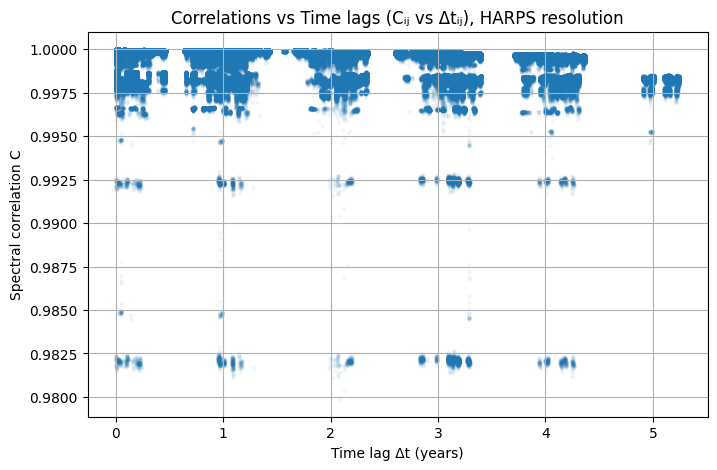

In [ ]:
# scatter
plt.figure(figsize=(8,5))
plt.scatter(dt_arr/365.25, corr_arr, s=5, alpha=0.04, marker='o')
plt.xlabel('Time lag Δt (years)')
plt.ylabel('Spectral correlation C')
plt.title('Correlations vs Time lags (Cᵢⱼ vs Δtᵢⱼ), HARPS resolution')
plt.grid(True)
plt.show()

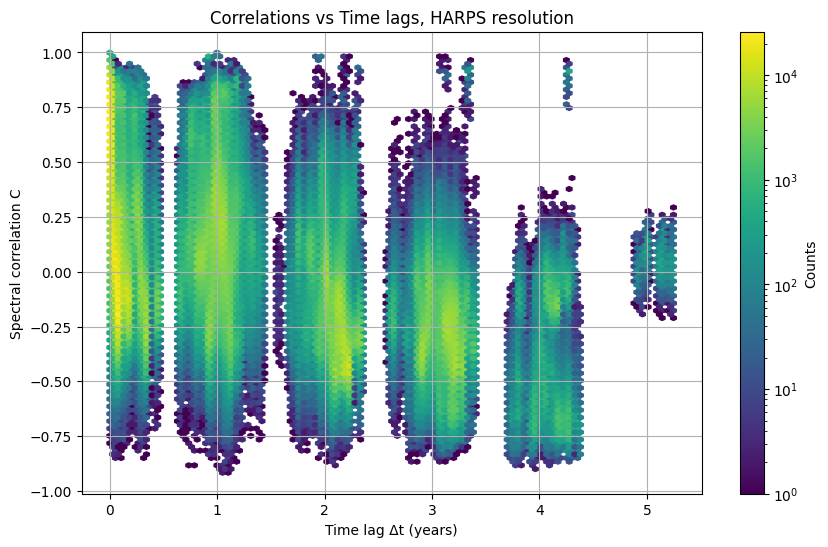

In [8]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,6))
plt.hexbin(dt_arr/365.25, corr_arr, gridsize=100, mincnt=1, norm=LogNorm())                   
plt.xlabel('Time lag Δt (years)')
plt.ylabel('Spectral correlation C')
plt.title('Correlations vs Time lags, HARPS resolution')
cb = plt.colorbar(label='Counts')
plt.grid(True)
plt.show()


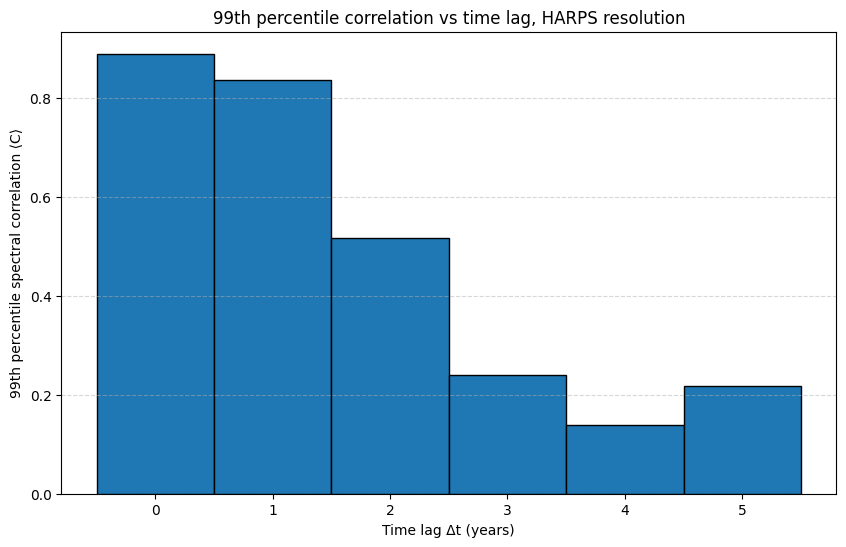

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# assume dt_arr and corr_arr are your original arrays
# convert time‐lags to years:
dt_years = dt_arr / 365.25

# define bin edges at [-0.5, 0.5, 1.5, 2.5, ...] up to max(dt_years)
bin_width = 1
bin_edges = np.arange(-bin_width/2, np.ceil(dt_years.max()) + bin_width, bin_width)

# digitize each dt into a bin index
bin_idx = np.digitize(dt_years, bin_edges)

# compute the bin centers for plotting
bin_centers = bin_edges[:-1] + 0.5

# compute mean correlation in each bin
means = []
for i in range(1, len(bin_edges)):
    sel = corr_arr[bin_idx == i]
    if len(sel) > 0:
        #means.append(sel.mean())
        means.append(np.percentile(sel,99.0))
    else:
        means.append(np.nan)   # or 0, or skip this bin

# now plot
plt.figure(figsize=(10,6))
plt.bar(bin_centers, means, width=bin_width, align='center', edgecolor='k')
plt.xlabel('Time lag Δt (years)')
plt.ylabel('99th percentile spectral correlation ⟨C⟩')
plt.title('99th percentile correlation vs time lag, HARPS resolution')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()
